In [6]:
%reset -f
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from aux import Generic
from lin_fit import fit_h, fit_h_train_test
from disp import set_font_size

DT = 0.1

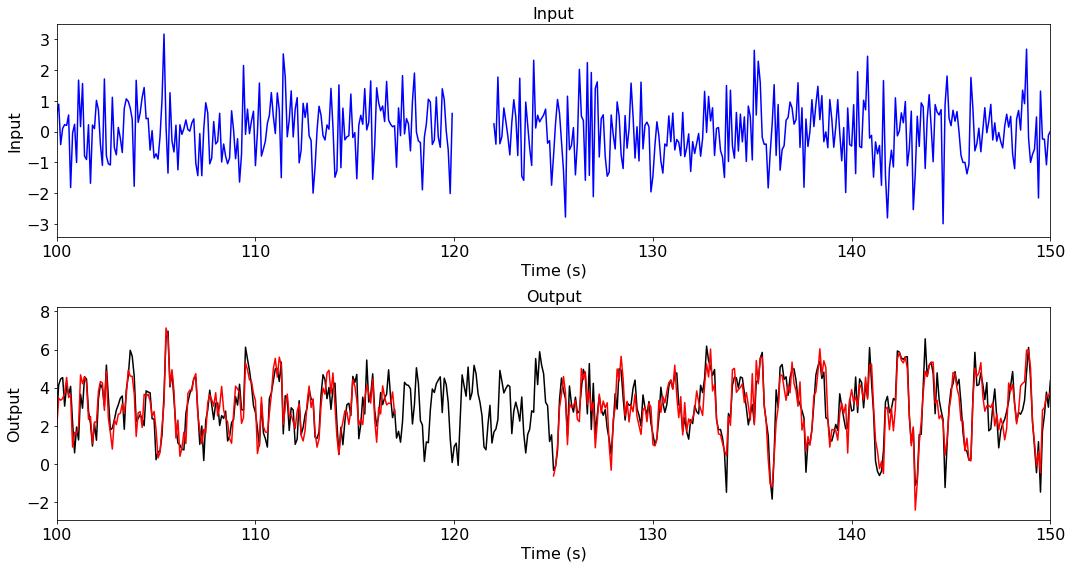

In [18]:
def test_fit_h():
    
    np.random.seed(0)

    # filter
    wdw = (-3, 0)
    t_h = np.arange(*wdw, DT)
    h = np.exp(t_h/1) * np.cos(4 * t_h)
    
    # mock data
    t = np.arange(0, 300, DT)
    x = np.random.normal(0, 1, t.shape)
    
    # convolve x with filter h
    y = np.convolve(x, np.concatenate([h, np.zeros(h.shape)])[::-1], mode='same') \
        + np.random.normal(0, .5, t.shape) + 3
        
    # throw in some nans
    x[int(120/DT):int(122/DT)] = np.nan
    
    # set up params for filter-fitting function
    xs = {'x': x}
    wdws_d = {'x': (int(round(wdw[0]/DT)), int(round(wdw[1]/DT)))}
    
    order = ['x']
    method = 'built-in'
    params = {'model': LinearRegression}
    
    # fit filters
    hs, icpt = fit_h(xs, y, wdws_d, order, method, params)
    
    h_hat = hs['x']
    
    # make predictions
    y_hat = np.convolve(x, np.concatenate([h_hat, np.zeros(h_hat.shape)])[::-1], mode='same') \
        + np.random.normal(0, .5, t.shape) + icpt
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 8), tight_layout=True)
    
    axs[0].plot(t, x, color='b')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Input')
    axs[0].set_title('Input')
    
    axs[1].plot(t, y, color='k')
    axs[1].plot(t, y_hat, color='r')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Output')
    axs[1].set_title('Output')
    
    for ax in axs:
        ax.set_xlim(100, 150)
        set_font_size(ax, 16)
    
test_fit_h()

In [2]:
raise Exception

def test_fit_filter(t_lim, method, params, C):
    
    for test_ctr in range(2):
        
        np.random.seed(0)

        # mock data
        t = np.arange(0, 300, C.DT)
        x = np.random.normal(0, 1, t.shape)

        if test_ctr == 0:
            
            wdw = (-3, 0)
            t_h = np.arange(*wdw, C.DT)
            h = np.exp(t_h/1) * np.cos(4 * t_h)
            h /= np.linalg.norm(h)

            y = np.convolve(x, np.concatenate([h, np.zeros(h.shape)])[::-1], mode='same') \
                + np.random.normal(0, .5, t.shape)
                
        elif test_ctr == 1:
    
            wdw = (-1.5, 1.5)
            t_h = np.arange(*wdw, C.DT)
            h = np.exp(-np.abs(t_h)/1) * np.sin(4 * t_h)
            h /= np.linalg.norm(h)

            y = np.convolve(x, h[::-1], mode='same') \
                + np.random.normal(0, .5, t.shape)

        # mock data loader
        dl = Generic(t=t, x=x, y=y)

        # mock trial
        trial = Generic(name='test_trial', dl=dl)

        # fit function
        rslt = fit_h_train_test(
            trial, 'x', 'y', wdw, 16, 4, method=method, params=params, C=C)

        # plot true and found filters
        gs = gridspec.GridSpec(2, 4)

        fig = plt.figure(figsize=(16, 6), tight_layout=True)
        ax_0 = fig.add_subplot(gs[0, :3])
        ax_1 = fig.add_subplot(gs[1, :3], sharex=ax_0)
        ax_2 = fig.add_subplot(gs[:, 3])

        # plot x, y, y_hat_train, y_hat_test
        ax_0.plot(t, x, color='k', alpha=0.3)
        ax_0.plot(t, y, color='b')

        ax_0.set_ylabel('x, y')
        ax_0.set_title('{0}: R^2 train = {1:.2f}, R^2 test = {2:.2f}'.format(
            rslt.trial_name, rslt.r2_train, rslt.r2_test))

        ax_0.legend(['x', 'y'], ncol=2)

        ax_1.plot(t, x, color='k', alpha=0.3)
        ax_1.plot(t, y, color='b')
        ax_1.plot(t, rslt.y_hat_train, color='r')
        ax_1.plot(t, rslt.y_hat_test, color='g')

        ax_1.set_xlim(*t_lim)

        ax_1.set_xlabel('time (s)')
        ax_1.set_ylabel('x, y, y_hat')
        ax_1.legend(['x', 'y', 'y_hat_train', 'y_hat_test'], ncol=4)

        # plot filters
        ax_2.plot(t_h, h, color='b')
        ax_2.plot(t_h, rslt.h, color='g')

        ax_2.grid()

        ax_2.set_xlabel('t rel. to prediction (s)')
        ax_2.set_ylabel('h')

        ax_2.legend(['true', 'inferred'])

        for ax in [ax_0, ax_1, ax_2]:
            set_font_size(ax, 16)
        
test_fit_filter([100, 130], 'built-in', {'model': LinearRegression}, C)

AttributeError: 'tuple' object has no attribute 'items'

Test passed if 2nd and 4th row show both red and green following blue line, and if true and inferred filters align for both figures.